# Setup

In [ ]:
import math
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import json
from scipy.stats import gaussian_kde

from typing import Any, Dict, Tuple, List, Optional

import tensorflow as tf
from sklearn.metrics import (
    r2_score,
    mean_squared_error,
    mean_absolute_error,
    median_absolute_error,
    explained_variance_score
)

import datetime

from geexhp import datavis as dvis
dvis.configure_matplotlib()

In [ ]:
#gpu_info = !nvidia-smi
#gpu_info = '\n'.join(gpu_info)
#if gpu_info.find('failed') >= 0:
#  print('Not connected to a GPU')
#else:
#  print(gpu_info)

Sun Mar  9 12:38:49 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.54.15              Driver Version: 550.54.15      CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  NVIDIA A100-SXM4-40GB          Off |   00000000:00:04.0 Off |                    0 |
| N/A   31C    P0             44W /  400W |       0MiB /  40960MiB |      0%      Default |
|                                         |                        |             Disabled |
+-----------------------------------------+-----

In [3]:
def parse_example(
    example_proto: tf.Tensor,
    input_stats: Dict[str, Tuple[float, float]],
    output_stats: Dict[str, Any]
) -> Tuple[Dict[str, tf.Tensor], Dict[str, List[tf.Tensor]]]:
    """
    Parse a single tf.train.Example proto using provided normalization statistics.

    Parameters
    ----------
    example_proto : tf.Tensor
        A serialized Example proto containing raw features.
    input_stats : dict
        Normalization statistics for input features. Keys are regions ('UV', 'Vis', 'NIR')
        with corresponding tuples (mean, std).
    output_stats : dict
        Normalization and transformation statistics for output features.

    Returns
    -------
    tuple
        A tuple (normalized_inputs, grouped_outputs) where:
          - normalized_inputs is a dict mapping feature names to normalized tf.Tensor inputs.
          - grouped_outputs is a dict with keys 'physical_output', 'main_chemical_output',
            and 'other_chemical_output', each containing a list of processed output tensors.
    """
    # 1) Define raw feature schemas.
    raw_input_features = {
        'NOISY_ALBEDO_B-NIR': tf.io.VarLenFeature(tf.float32),
        'NOISY_ALBEDO_B-UV':  tf.io.VarLenFeature(tf.float32),
        'NOISY_ALBEDO_B-Vis': tf.io.VarLenFeature(tf.float32),
    }

    raw_output_features = {
        # Planetary parameters.
        "OBJECT-RADIUS-REL-EARTH": tf.io.FixedLenFeature([], tf.float32),
        "OBJECT-GRAVITY":           tf.io.FixedLenFeature([], tf.float32),
        "ATMOSPHERE-TEMPERATURE":   tf.io.FixedLenFeature([], tf.float32),
        "ATMOSPHERE-PRESSURE":      tf.io.FixedLenFeature([], tf.float32),

        # Chemical abundances.
        'CH4':  tf.io.FixedLenFeature([], tf.float32),
        'CO':   tf.io.FixedLenFeature([], tf.float32),
        'CO2':  tf.io.FixedLenFeature([], tf.float32),
        'H2O':  tf.io.FixedLenFeature([], tf.float32),
        'N2':   tf.io.FixedLenFeature([], tf.float32),
        'N2O':  tf.io.FixedLenFeature([], tf.float32),
        'O2':   tf.io.FixedLenFeature([], tf.float32),
        'O3':   tf.io.FixedLenFeature([], tf.float32),

        # 'Earth_type': tf.io.FixedLenFeature([], tf.string)
    }

    # 2) Parse the example.
    all_features = {**raw_input_features, **raw_output_features}
    parsed = tf.io.parse_single_example(example_proto, all_features)

    # 3) Normalize input spectra.
    normalized_inputs = {}
    for region in ['UV', 'Vis', 'NIR']:
        spectrum = parsed[f'NOISY_ALBEDO_B-{region}']
        if isinstance(spectrum, tf.SparseTensor):
            spectrum = tf.sparse.to_dense(spectrum, default_value=0.0)

        mean = input_stats[region][0]
        std  = input_stats[region][1]
        normalized = (spectrum - mean) / std

        # Reshape for model (example shape)
        if region == 'UV':
            normalized = tf.reshape(normalized, [8, 1])
        elif region == 'Vis':
            normalized = tf.reshape(normalized, [94, 1])
        elif region == 'NIR':
            normalized = tf.reshape(normalized, [49, 1])

        normalized_inputs[f'NOISY_ALBEDO_B-{region}'] = normalized

    # 4) Process outputs.
    physical_outputs = []
    main_chemical_outputs = []
    other_chemical_outputs = []

    # 4a) Process planetary parameters (physical outputs).
    for param in ["OBJECT-RADIUS-REL-EARTH", "OBJECT-GRAVITY",
                    "ATMOSPHERE-TEMPERATURE", "ATMOSPHERE-PRESSURE"]:
        val = parsed[param]
        # To avoid a very ponctual error we found
        # the floating point precision error generates a single NaN value here :(
        if val == 273.15:
            val += 0.00002
        min_  = output_stats['physical_output_stats'][param][0]
        max_  = output_stats['physical_output_stats'][param][1]
        best_n  = output_stats['physical_output_stats'][param][2]
        processed = (val - min_) / (max_ - min_)
        processed = tf.math.pow(float(processed), float(1/best_n))
        physical_outputs.append(processed)

    # 4b) Process main chemical abundances.
    for chem in ['O2', 'O3']:
        val = parsed[chem]
        best_n = output_stats['chemical_output_stats'][chem]["best_n"]
        processed = tf.math.pow(float(val), float(1/best_n))
        main_chemical_outputs.append(processed)

    # 4c) Process other chemical abundances.
    for chem in ['CH4', 'CO', 'CO2', 'H2O', 'N2', 'N2O']:
        val = parsed[chem]
        best_n = output_stats['chemical_output_stats'][chem]["best_n"]
        processed = tf.math.pow(float(val), float(1 / best_n))
        other_chemical_outputs.append(processed)

    grouped_outputs = {
        'physical_output': physical_outputs,              # shape (4,)
        'main_chemical_output': main_chemical_outputs,    # shape (2,)
        'other_chemical_output': other_chemical_outputs,  # shape (7,)
        #'earth_type': parsed['Earth_type']               # shape (1,)
    }

    return normalized_inputs, grouped_outputs


def read_tfrecord(
    file_path: str,
    batch_size: int = 1024,
    shuffle_buffer: Optional[int] = None,
    repeat: bool = False
) -> tf.data.Dataset:
    """
    Read a TFRecord file, parse its examples, and return a batched tf.data.Dataset.

    Parameters
    ----------
    file_path : str
        Path to the TFRecord file.
    batch_size : int, optional
        Number of samples per batch, by default 256.
    shuffle_buffer : int, optional
        Buffer size for shuffling. If None or <= 0, shuffling is not applied.
    repeat : bool, optional
        Whether to repeat the dataset indefinitely, by default False.

    Returns
    -------
    tf.data.Dataset
        A dataset of parsed examples, batched and prefetched.
    """
    with open('/content/drive/MyDrive/dados/normalization_stats.json') as f:
        stats = json.load(f)

    # Create lookup dictionaries for input normalization statistics.
    input_stats = {
        'UV': (stats['inputs']['B-UV']['mean'], stats['inputs']['B-UV']['std']),
        'Vis': (stats['inputs']['B-Vis']['mean'], stats['inputs']['B-Vis']['std']),
        'NIR': (stats['inputs']['B-NIR']['mean'], stats['inputs']['B-NIR']['std'])
    }

    physical_keys = ["OBJECT-RADIUS-REL-EARTH", "OBJECT-GRAVITY",
                    "ATMOSPHERE-TEMPERATURE", "ATMOSPHERE-PRESSURE"]
    physical_output_stats = {
        key: (stats['outputs'][key]['min'], stats['outputs'][key]['max'], stats['outputs'][key]['best_n'])
        for key in physical_keys
    }

    chemical_keys = ['CH4', 'CO', 'CO2', 'H2O', 'N2', 'N2O', 'O2', 'O3']
    chemical_output_stats = {
        key: stats['outputs'][key] for key in chemical_keys
    }

    output_stats: Dict[str, Any] = {
        'physical_output_stats': physical_output_stats,
        'chemical_output_stats': chemical_output_stats
    }

    dataset = tf.data.TFRecordDataset(file_path, num_parallel_reads=tf.data.AUTOTUNE)

    if shuffle_buffer is not None and shuffle_buffer > 0:
        dataset = dataset.shuffle(buffer_size=shuffle_buffer)

    # Parse the dataset using the parse_example function.
    parsed_dataset = dataset.map(
        lambda x: parse_example(x, input_stats, output_stats),
        num_parallel_calls=tf.data.AUTOTUNE
    )

    if repeat:
        parsed_dataset = parsed_dataset.repeat()

    parsed_dataset = parsed_dataset.batch(batch_size, drop_remainder=False)
    parsed_dataset = parsed_dataset.prefetch(tf.data.AUTOTUNE)

    return parsed_dataset

In [4]:
train_ds = read_tfrecord("/content/drive/MyDrive/dados/train.tfrecord", shuffle_buffer=800000, repeat=True)
val_ds   = read_tfrecord("/content/drive/MyDrive/dados/val.tfrecord", shuffle_buffer=80000, repeat=True)
test_ds  = read_tfrecord("/content/drive/MyDrive/dados/test.tfrecord")

In [5]:
TRAIN_SAMPLES = 892073
VAL_SAMPLES = 107422
BATCH_SIZE = 1024

steps_per_epoch = math.ceil(TRAIN_SAMPLES / BATCH_SIZE)
validation_steps = math.ceil(VAL_SAMPLES / BATCH_SIZE)

# The best model

In [ ]:
def residual_block_1D(x,
                      num_filters=32,
                      kernel_size=3,
                      activation='swish',
                      padding='same',
                      strides = 1
                      ):

    shortcut = x

    # First Conv
    y = tf.keras.layers.Conv1D(num_filters, kernel_size, padding=padding, activation=None)(x)
    y = tf.keras.layers.BatchNormalization()(y)
    y = tf.keras.layers.Activation(activation)(y)

    # Second Conv
    y = tf.keras.layers.Conv1D(num_filters, kernel_size, padding=padding, activation=None)(y)
    y = tf.keras.layers.BatchNormalization()(y)

    # Skip connection
    y = tf.keras.layers.Add()([shortcut, y])
    y = tf.keras.layers.Activation(activation)(y)

    y = tf.keras.layers.MaxPooling1D(pool_size=1)(y)

    y = tf.keras.layers.Conv1D(num_filters, kernel_size, padding=padding, strides=strides, activation=None)(y)

    return y

In [ ]:
def small_transformer_block(x,
                            num_heads=4,
                            key_dim=32
                            ):

    # Self-Attention
    attn_output = tf.keras.layers.MultiHeadAttention(num_heads=num_heads, key_dim=key_dim)(x, x)
    x = tf.keras.layers.Add()([x, attn_output])
    x = tf.keras.layers.LayerNormalization()(x)

    # Feed-forward
    ff = tf.keras.layers.Dense(64, activation='swish')(x)
    ff = tf.keras.layers.Dense(x.shape[-1])(ff)  # project back to input feature dim
    x = tf.keras.layers.Add()([x, ff])
    x = tf.keras.layers.LayerNormalization()(x)

    return x

In [ ]:
def build_model():
    """
    Creates a model with:
    - UV, VIS, NIR branches (each with conv+res+transformer)
    - Merged dense layers
    - Two sub-heads for (Physical parameters) and (Chemical abundances)
    """

    # ----------------------
    #  LISTS / CONSTANTS
    # ----------------------
    physical_targets = [
        "OBJECT-RADIUS-REL-EARTH",
        "OBJECT-GRAVITY",
        "ATMOSPHERE-TEMPERATURE",
        "ATMOSPHERE-PRESSURE"
    ]
    main_chemical_targets = ['O2', 'O3']
    other_chemical_targets = ['CH4', 'CO', 'CO2', 'H2O', 'N2', 'N2O']

    # -----------
    # INPUTS
    # -----------
    input_uv  = tf.keras.layers.Input(shape=(8, 1),  name='NOISY_ALBEDO_B-UV')
    input_vis = tf.keras.layers.Input(shape=(94, 1), name='NOISY_ALBEDO_B-Vis')
    input_nir = tf.keras.layers.Input(shape=(49, 1), name='NOISY_ALBEDO_B-NIR')

    spectrum_lenghth = 151

    spectrum = tf.keras.layers.Concatenate(axis=1)([input_uv, input_vis, input_nir])

    # It's a near‐global coverage
    spectrum = residual_block_1D(spectrum, num_filters=20, kernel_size=int(spectrum_lenghth/4), strides=2)
    spectrum = residual_block_1D(spectrum, num_filters=20, kernel_size=int(spectrum_lenghth/2*4), strides=2)
    spectrum = small_transformer_block(spectrum, num_heads=2, key_dim=8)  # smaller since only 8 channels in UV
    spectrum = tf.keras.layers.GlobalAveragePooling1D()(spectrum)  # or Flatten

    shortcut = tf.keras.layers.Dense(32, kernel_initializer="he_normal")(spectrum)
    x = tf.keras.layers.Dropout(0.3)(shortcut)

    x = tf.keras.layers.Dense(32, kernel_initializer="he_normal")(x)
    x = tf.keras.layers.Dropout(0.3)(x)
    x = tf.keras.layers.Dense(32, kernel_initializer="he_normal")(x)
    x = tf.keras.layers.Dropout(0.3)(x)

    x = tf.keras.layers.Add()([shortcut, x])

    # ------------------------
    #   SUB-HEADS
    # ------------------------
    # Physical parameters (4 outputs)
    phys = tf.keras.layers.Dense(16, kernel_initializer="glorot_uniform")(x)
    phys_out = tf.keras.layers.Dense(
        len(physical_targets),
        activation='sigmoid',
        name='physical_output'
    )(phys)

    # Chemical abundances (2 outputs) - use ReLU(max_value=1.0)
    main_chem = tf.keras.layers.Dense(16, kernel_initializer="he_normal")(x)
    main_chem_out_dense = tf.keras.layers.Dense(
        len(main_chemical_targets),
        activation=None,                  # no activation in Dense
        name='main_chem_dense'
    )(main_chem)
    main_chem_out = tf.keras.layers.ReLU(
        max_value=1.0,
        name='main_chemical_output'
    )(main_chem_out_dense)

    # Chemical abundances (6 outputs) - use ReLU(max_value=1.0)
    other_chem = tf.keras.layers.Dense(16, kernel_initializer="he_normal")(x)
    other_chem_out_dense = tf.keras.layers.Dense(
        len(other_chemical_targets),
        activation=None,
        name='other_chem_dense'
    )(other_chem)
    other_chem_out = tf.keras.layers.ReLU(
        max_value=1.0,
        name='other_chemical_output'
    )(other_chem_out_dense)

    # -----------
    # MODEL
    # -----------
    outputs = {
        'physical_output': phys_out,
        'main_chemical_output': main_chem_out,
        'other_chemical_output': other_chem_out
    }
    model = tf.keras.Model(
        inputs=[input_uv, input_vis, input_nir],
        outputs=outputs,
        name="Net22"
    )
    # ---------------------------
    #    LOSSES & COMPILATION
    # ---------------------------
    # We'll use 'mae' for both heads.
    # By default, Keras will average the MAE across each sub-head's dimension.
    losses = {
        'physical_output': 'mae',
        'main_chemical_output': 'mae',
        'other_chemical_output': 'mae'
    }

    loss_weights = {
        'physical_output': 1.0,
        'main_chemical_output': 2.0,
        'other_chemical_output': 1.5
    }

    opt = tf.keras.optimizers.Adam(learning_rate=1e-4)

    model.compile(
        optimizer=opt,
        loss=losses,
        loss_weights=loss_weights
    )

    return model

In [ ]:
model = build_model()

if False:
    tf.keras.utils.plot_model(
    model,
    #to_file="network.png",
    show_shapes=True,
    show_dtype=False,
    show_layer_names=True,
    rankdir="TB",
    expand_nested=True,
    dpi=200,
    show_layer_activations=True,
    show_trainable=True
    )

In [ ]:
EPOCHS = 50

log_dir = "logs/fit22/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_callback = tf.keras.callbacks.TensorBoard(
    log_dir=log_dir,
    histogram_freq=1
)

reduce_lr_callback = tf.keras.callbacks.ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.1,       # How much to reduce LR by
    patience=3,       # Wait 3 epochs with no improvement before reducing LR
    min_lr=1e-7,      # Lower bound on LR
    cooldown=0,
    verbose=1
)

early_stop_callback = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=5,       # Number of epochs with no improvement after which training stops
    restore_best_weights=True,  # Revert to the best weights found during training
    verbose=1
)

history = model.fit(
    train_ds,
    epochs=EPOCHS,
    steps_per_epoch=steps_per_epoch,
    validation_data=val_ds,
    validation_steps=validation_steps,
    callbacks=[
        tensorboard_callback,
        reduce_lr_callback,
        early_stop_callback
    ]
)

Epoch 1/50
872/872 ━━━━━━━━━━━━━━━━━━━━ 92s 58ms/step - loss: 1.1391 - main_chemical_output_loss: 0.2129 - other_chemical_output_loss: 0.2832 - physical_output_loss: 0.2885 - val_loss: 0.4941 - val_main_chemical_output_loss: 0.0723 - val_other_chemical_output_loss: 0.0996 - val_physical_output_loss: 0.2001 - learning_rate: 1.0000e-04
Epoch 2/50
872/872 ━━━━━━━━━━━━━━━━━━━━ 47s 54ms/step - loss: 0.5616 - main_chemical_output_loss: 0.0887 - other_chemical_output_loss: 0.1235 - physical_output_loss: 0.1989 - val_loss: 0.4283 - val_main_chemical_output_loss: 0.0611 - val_other_chemical_output_loss: 0.0904 - val_physical_output_loss: 0.1705 - learning_rate: 1.0000e-04
Epoch 3/50
872/872 ━━━━━━━━━━━━━━━━━━━━ 82s 94ms/step - loss: 0.4837 - main_chemical_output_loss: 0.0758 - other_chemical_output_loss: 0.1094 - physical_output_loss: 0.1679 - val_loss: 0.3878 - val_main_chemical_output_loss: 0.0551 - val_other_chemical_output_loss: 0.0869 - val_physical_output_loss: 0.1473 - learning_rate: 1.0

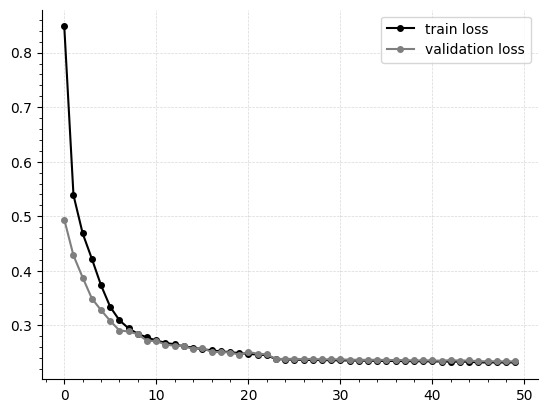

In [ ]:
plt.plot(range(EPOCHS), history.history["loss"], marker="o", label="train loss", color="k", markersize=4)
plt.plot(range(EPOCHS), history.history["val_loss"], marker="o", label="validation loss", color="tab:gray", markersize=4)
plt.legend();

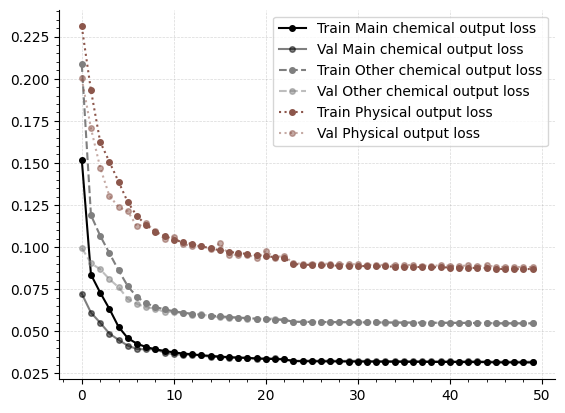

In [ ]:
plt.plot(range(EPOCHS), history.history["main_chemical_output_loss"], marker="o", label="Train Main chemical output loss", color="k", markersize=4)
plt.plot(range(EPOCHS), history.history["val_main_chemical_output_loss"], marker="o", label="Val Main chemical output loss", color="k", alpha=0.5, markersize=4)

plt.plot(range(EPOCHS), history.history["other_chemical_output_loss"], marker="o", ls="dashed", label="Train Other chemical output loss", color="tab:gray", markersize=4)
plt.plot(range(EPOCHS), history.history["val_other_chemical_output_loss"], marker="o", ls="dashed", label="Val Other chemical output loss", color="tab:gray", alpha=0.5, markersize=4)

plt.plot(range(EPOCHS), history.history["physical_output_loss"], marker="o", ls="dotted", label="Train Physical output loss", color="tab:brown", markersize=4)
plt.plot(range(EPOCHS), history.history["val_physical_output_loss"], marker="o", ls="dotted", label="Val Physical output loss", color="tab:brown", alpha=0.5, markersize=4)

plt.legend();

In [ ]:
y_true_phys_all = []
y_true_main_chem_all = []
y_true_other_chem_all = []

y_pred_phys_all = []
y_pred_main_chem_all = []
y_pred_other_chem_all = []

for x_batch, y_batch in test_ds:
    # 1) Get model predictions for this batch
    predictions = model(x_batch, training=False)
    pred_phys_batch = predictions['physical_output']
    pred_main_chem_batch = predictions['main_chemical_output']
    pred_other_chem_batch = predictions['other_chemical_output']

    # 2) Collect ground-truth values
    true_phys_batch = y_batch['physical_output']
    true_main_chem_batch = y_batch['main_chemical_output']
    true_other_chem_batch = y_batch['other_chemical_output']

    # 3) Append to our running lists
    y_true_phys_all.append(true_phys_batch.numpy())
    y_true_main_chem_all.append(true_main_chem_batch.numpy())
    y_true_other_chem_all.append(true_other_chem_batch.numpy())

    y_pred_phys_all.append(pred_phys_batch.numpy())
    y_pred_main_chem_all.append(pred_main_chem_batch.numpy())
    y_pred_other_chem_all.append(pred_other_chem_batch.numpy())

# 4) Concatenate the list of batches into a single array for each head
y_true_phys_all = np.concatenate(y_true_phys_all, axis=0)
y_true_main_chem_all = np.concatenate(y_true_main_chem_all, axis=0)
y_true_other_chem_all = np.concatenate(y_true_other_chem_all, axis=0)

y_pred_phys_all = np.concatenate(y_pred_phys_all, axis=0)
y_pred_main_chem_all = np.concatenate(y_pred_main_chem_all, axis=0)
y_pred_other_chem_all = np.concatenate(y_pred_other_chem_all, axis=0)


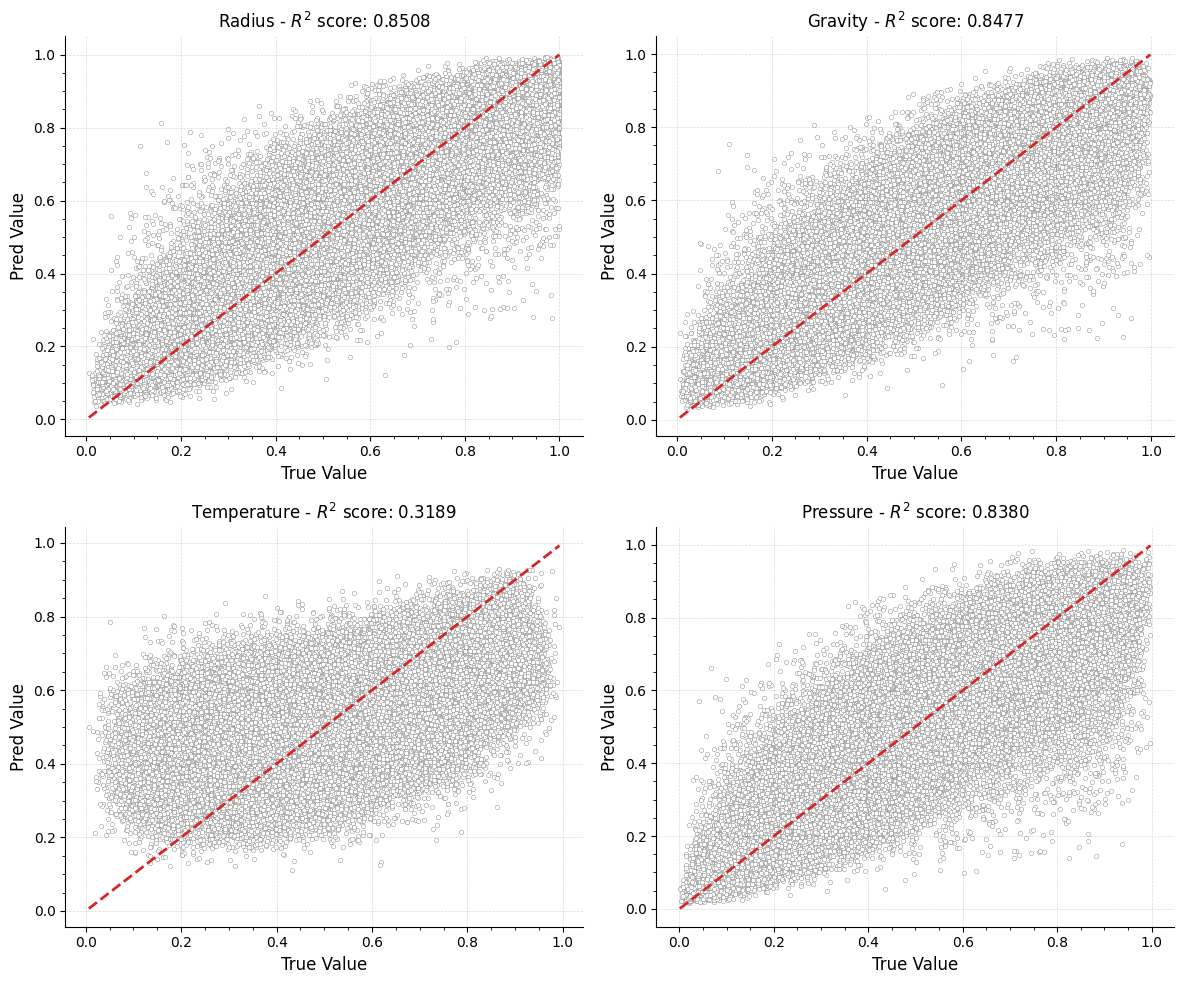

In [ ]:
physical_parameters = ['Radius', 'Gravity', 'Temperature', 'Pressure']
n_keys = len(physical_parameters)
n_cols = 2
n_rows = int(np.ceil(n_keys / n_cols))

plt.figure(figsize=(12, 10))

metrics_list = []

for i, phys_param in enumerate(physical_parameters):
    phys_true = np.array([y_true_phys_all[row][i] for row in range(len(y_true_phys_all))])
    phys_pred = np.array([y_pred_phys_all[row][i] for row in range(len(y_pred_phys_all))])

    min_val = min(phys_true.min(), phys_pred.min())
    max_val = max(phys_true.max(), phys_pred.max())

    r2 = r2_score(phys_true, phys_pred)

    ax = plt.subplot(n_rows, n_cols, i+1)
    ax.plot([min_val, max_val], [min_val, max_val], ls="--", color="tab:red", lw=2)

    # Compute density using a 2D histogram
    #nbins = 100
    #hist, xedges, yedges = np.histogram2d(phys_true, phys_pred, bins=nbins)
    # For each point, determine which bin it falls into
    #xidx = np.clip(np.searchsorted(xedges, phys_true) - 1, 0, nbins-1)
    #yidx = np.clip(np.searchsorted(yedges, phys_pred) - 1, 0, nbins-1)
    # Map each point to its density value (the count in its bin)
    #z = hist[xidx, yidx]

    #sc = ax.scatter(phys_true, phys_pred, c=z, s=5, cmap='Greys_r', edgecolor='none')
    ax.scatter(phys_true, phys_pred, s=10, edgecolor="tab:gray", linewidth=0.3, color="w")
    #cb = plt.colorbar(sc, ax=ax, pad=0)
    #cb.set_label("Density")

    ax.set_title(fr'{physical_parameters[i]} - $R^2$ score: {r2:.4f}')
    ax.set_xlabel("True Value")
    ax.set_ylabel("Pred Value")

    mse = mean_squared_error(phys_true, phys_pred)
    rmse = np.sqrt(mse)
    mae = mean_absolute_error(phys_true, phys_pred)
    med_ae = median_absolute_error(phys_true, phys_pred)
    exp_var = explained_variance_score(phys_true, phys_pred)

    metrics_list.append({
        "Output": phys_param,
        "R²": r2,
        "Explained Variance": exp_var,
        "MSE": mse,
        "RMSE": rmse,
        "MAE": mae,
        "Median Absolute Error": med_ae
    })

df_metrics = pd.DataFrame(metrics_list)
plt.tight_layout();

In [ ]:
df_metrics

Output        R²  Explained Variance       MSE      RMSE       MAE  \
0       Radius  0.850762            0.850775  0.009652  0.098243  0.072765   
1      Gravity  0.847743            0.847744  0.009869  0.099344  0.073219   
2  Temperature  0.318923            0.321067  0.026793  0.163687  0.131094   
3     Pressure  0.838008            0.838178  0.010905  0.104428  0.074287   

   Median Absolute Error  
0               0.054679  
1               0.054597  
2               0.111410  
3               0.052005

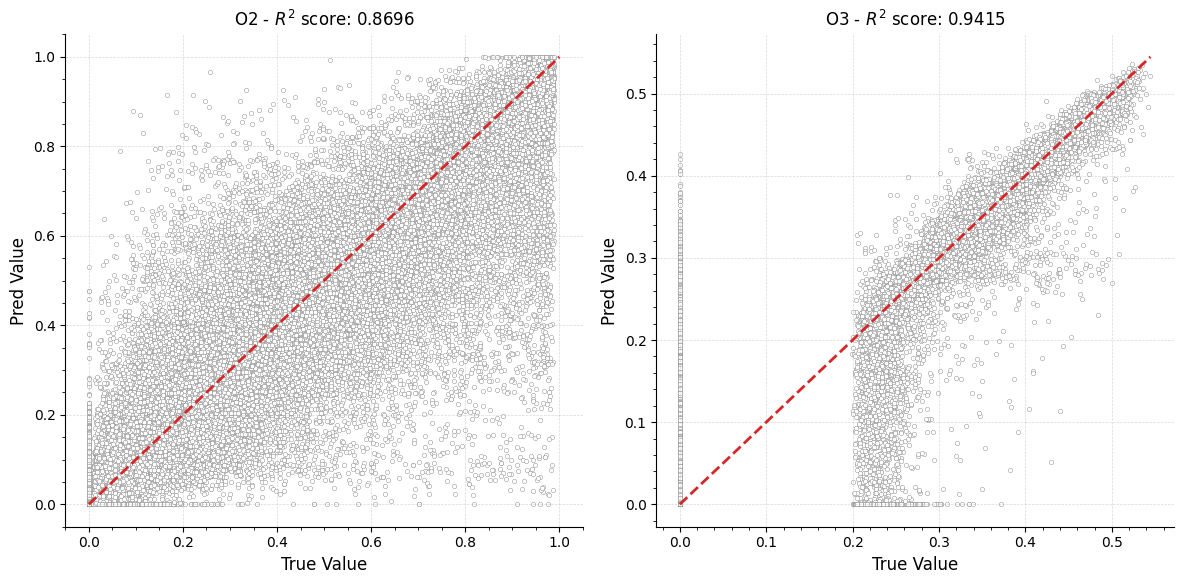

In [ ]:
main_chemical_parameters = ['O2', 'O3']

n_keys = len(main_chemical_parameters)
n_cols = 2
n_rows = int(np.ceil(n_keys / n_cols))

plt.figure(figsize=(12, 6))

metrics_list = []

for i, chem_param in enumerate(main_chemical_parameters):
    chem_true = np.array([y_true_main_chem_all[row][i] for row in range(len(y_true_main_chem_all))])
    chem_pred = np.array([y_pred_main_chem_all[row][i] for row in range(len(y_pred_main_chem_all))])

    min_val = min(chem_true.min(), chem_pred.min())
    max_val = max(chem_true.max(), chem_pred.max())

    r2 = r2_score(chem_true, chem_pred)

    ax = plt.subplot(n_rows, n_cols, i+1)
    ax.plot([min_val, max_val], [min_val, max_val], ls="--", color="tab:red", lw=2)

    # Compute density using a 2D histogram
    #nbins = 50
    #hist, xedges, yedges = np.histogram2d(chem_true, chem_pred, bins=nbins)
    #xidx = np.clip(np.searchsorted(xedges, chem_true) - 1, 0, nbins-1)
    #yidx = np.clip(np.searchsorted(yedges, chem_pred) - 1, 0, nbins-1)
    #z = hist[xidx, yidx]

    # Scatter plot using density as color, with Greys_r cmap
    #sc = ax.scatter(chem_true, chem_pred, s=5, c=z, cmap='Greys_r', edgecolor="none", linewidth=0.3)
    ax.scatter(chem_true, chem_pred, s=10, edgecolor="tab:gray", linewidth=0.3, color="w")

    # Add colorbar with label "Density"
    #cb = plt.colorbar(sc, ax=ax, pad=0)
    #cb.set_label("Density")

    ax.set_title(fr'{main_chemical_parameters[i]} - $R^2$ score: {r2:.4f}')
    ax.set_xlabel("True Value")
    ax.set_ylabel("Pred Value")

    mse = mean_squared_error(chem_true, chem_pred)
    rmse = np.sqrt(mse)
    mae = mean_absolute_error(chem_true, chem_pred)
    med_ae = median_absolute_error(chem_true, chem_pred)
    exp_var = explained_variance_score(chem_true, chem_pred)

    metrics_list.append({
        "Output": chem_param,
        "R²": r2,
        "Explained Variance": exp_var,
        "MSE": mse,
        "RMSE": rmse,
        "MAE": mae,
        "Median Absolute Error": med_ae
    })

df_metrics_chem = pd.DataFrame(metrics_list)
plt.tight_layout()
plt.show()

In [ ]:
df_metrics_chem

Output        R²  Explained Variance       MSE      RMSE       MAE  \
0     O2  0.869645            0.870772  0.011538  0.107416  0.055020   
1     O3  0.941532            0.941579  0.001650  0.040616  0.013354   

   Median Absolute Error  
0               0.019651  
1               0.003132

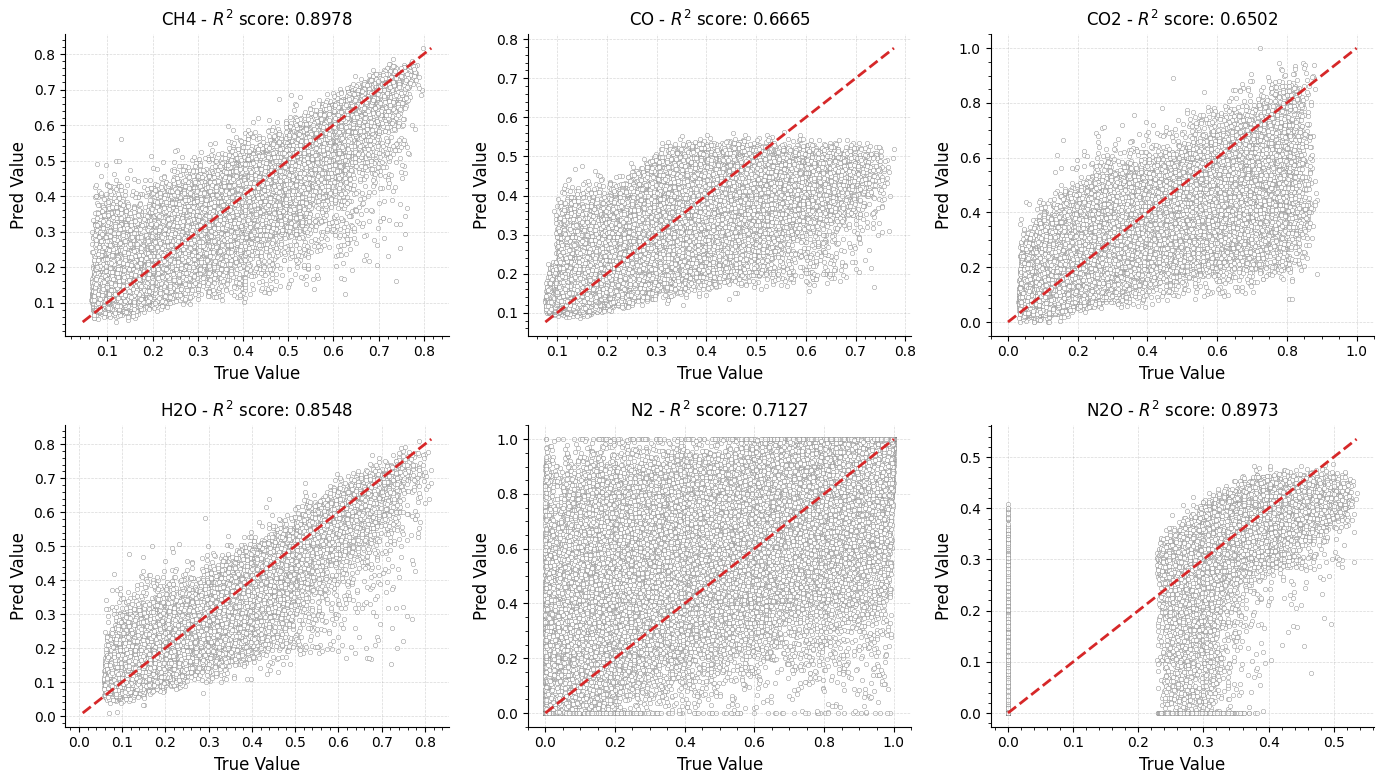

In [ ]:
other_chemical_parameters = ['CH4', 'CO', 'CO2', 'H2O', 'N2', 'N2O']

n_keys = len(other_chemical_parameters)
n_cols = 3
n_rows = 2
plt.figure(figsize=(14, 8))

metrics_list = []

for i, chem_param in enumerate(other_chemical_parameters):
    chem_true = np.array([y_true_other_chem_all[row][i] for row in range(len(y_true_other_chem_all))])
    chem_pred = np.array([y_pred_other_chem_all[row][i] for row in range(len(y_pred_other_chem_all))])

    # Correct min and max values using both true and pred arrays
    min_val = min(chem_true.min(), chem_pred.min())
    max_val = max(chem_true.max(), chem_pred.max())

    r2 = r2_score(chem_true, chem_pred)

    ax = plt.subplot(n_rows, n_cols, i+1)
    ax.plot([min_val, max_val], [min_val, max_val], ls="--", color="tab:red", lw=2)

    # Compute density with a 2D histogram
    #nbins = 100
    #hist, xedges, yedges = np.histogram2d(chem_true, chem_pred, bins=nbins)
    #xidx = np.clip(np.searchsorted(xedges, chem_true) - 1, 0, nbins-1)
    #yidx = np.clip(np.searchsorted(yedges, chem_pred) - 1, 0, nbins-1)
    #z = hist[xidx, yidx]

    # Create the scatter plot using density for the color (Greys_r)
    #sc = ax.scatter(chem_true, chem_pred, s=5, c=z, cmap='Greys_r', edgecolor="none", linewidth=0.3)
    ax.scatter(chem_true, chem_pred, s=10, edgecolor="tab:gray", linewidth=0.3, color="w")

    # Add a colorbar with label "Density"
    #cb = plt.colorbar(sc, ax=ax, pad=0)
    #cb.set_label("Density")

    ax.set_title(fr'{other_chemical_parameters[i]} - $R^2$ score: {r2:.4f}')
    ax.set_xlabel("True Value")
    ax.set_ylabel("Pred Value")

    mse = mean_squared_error(chem_true, chem_pred)
    rmse = np.sqrt(mse)
    mae = mean_absolute_error(chem_true, chem_pred)
    med_ae = median_absolute_error(chem_true, chem_pred)
    exp_var = explained_variance_score(chem_true, chem_pred)

    metrics_list.append({
        "Output": chem_param,
        "R²": r2,
        "Explained Variance": exp_var,
        "MSE": mse,
        "RMSE": rmse,
        "MAE": mae,
        "Median Absolute Error": med_ae
    })

plt.tight_layout()

df_metrics_chem = pd.DataFrame(metrics_list)
plt.show()

In [ ]:
df_metrics_chem

Output        R²  Explained Variance       MSE      RMSE       MAE  \
0    CH4  0.897816            0.897914  0.002746  0.052399  0.034740   
1     CO  0.666451            0.672130  0.005974  0.077295  0.055241   
2    CO2  0.650163            0.655461  0.010880  0.104305  0.070549   
3    H2O  0.854755            0.854965  0.002126  0.046107  0.029963   
4     N2  0.712738            0.720042  0.030623  0.174995  0.106170   
5    N2O  0.897299            0.897590  0.003139  0.056026  0.030238   

   Median Absolute Error  
0               0.023703  
1               0.039700  
2               0.046125  
3               0.018854  
4               0.051093  
5               0.017297

In [ ]:
model.save('/content/drive/MyDrive/Colab Notebooks/NN_22-01-colab.keras')

# Bayesian tuner

In [ ]:
#%%capture
#!pip install keras-tuner

import kerastuner as kt

In [8]:
def residual_block_1D(x,
                      num_filters=32,
                      kernel_size=3,
                      activation='swish',
                      padding='same',
                      strides=1):
    shortcut = x
    # First Conv
    y = tf.keras.layers.Conv1D(num_filters, kernel_size, padding=padding, activation=None)(x)
    y = tf.keras.layers.BatchNormalization()(y)
    y = tf.keras.layers.Activation(activation)(y)
    # Second Conv
    y = tf.keras.layers.Conv1D(num_filters, kernel_size, padding=padding, activation=None)(y)
    y = tf.keras.layers.BatchNormalization()(y)
    # Skip connection
    y = tf.keras.layers.Add()([shortcut, y])
    y = tf.keras.layers.Activation(activation)(y)
    y = tf.keras.layers.MaxPooling1D(pool_size=1)(y)
    y = tf.keras.layers.Conv1D(num_filters, kernel_size, padding=padding, strides=strides, activation=None)(y)
    return y

def small_transformer_block(x,
                            num_heads=4,
                            key_dim=32):
    # Self-Attention
    attn_output = tf.keras.layers.MultiHeadAttention(num_heads=num_heads, key_dim=key_dim)(x, x)
    x = tf.keras.layers.Add()([x, attn_output])
    x = tf.keras.layers.LayerNormalization()(x)
    # Feed-forward
    ff = tf.keras.layers.Dense(64, activation='swish')(x)
    ff = tf.keras.layers.Dense(x.shape[-1])(ff)  # project back to input feature dim
    x = tf.keras.layers.Add()([x, ff])
    x = tf.keras.layers.LayerNormalization()(x)
    return x

def build_model(hp):
    """
    HyperModel for your CNN with Bayesian optimization. The model:
      - Takes three spectral inputs (UV, VIS, NIR)
      - Merges them and applies two residual blocks with large kernel sizes for near-global coverage
      - Applies a small transformer block
      - Uses dense layers with dropout, and two sub-heads for physical and chemical outputs.
    """
    # ----------------------
    #  Target Definitions
    # ----------------------
    physical_targets = [
        "OBJECT-RADIUS-REL-EARTH",
        "OBJECT-GRAVITY",
        "ATMOSPHERE-TEMPERATURE",
        "ATMOSPHERE-PRESSURE"
    ]
    main_chemical_targets = ['O2', 'O3']
    other_chemical_targets = ['CH4', 'CO', 'CO2', 'H2O', 'N2', 'N2O']

    # ----------------------
    #   Input Layers
    # ----------------------
    input_uv  = tf.keras.layers.Input(shape=(8, 1),  name='NOISY_ALBEDO_B-UV')
    input_vis = tf.keras.layers.Input(shape=(94, 1), name='NOISY_ALBEDO_B-Vis')
    input_nir = tf.keras.layers.Input(shape=(49, 1), name='NOISY_ALBEDO_B-NIR')
    # Concatenate along the spectral dimension.
    spectrum = tf.keras.layers.Concatenate(axis=1)([input_uv, input_vis, input_nir])
    spectrum_length = 151  # Total length (8 + 94 + 49)

    # ----------------------
    #   Hyperparameters
    # ----------------------
    # Convolutional block hyperparameters
    num_filters = hp.Int('num_filters', min_value=16, max_value=64, step=8, default=20)
    kernel_size_1 = hp.Choice('kernel_size_1',
                              values=[max(3, int(spectrum_length/4)), int(spectrum_length/3), int(spectrum_length/2)],
                              default=int(spectrum_length/4))
    kernel_size_2 = hp.Choice('kernel_size_2',
                              values=[int(spectrum_length/2), int(spectrum_length*0.75), spectrum_length],
                              default=int(spectrum_length/2))
    # Transformer block hyperparameters
    num_heads = hp.Int('num_heads', min_value=2, max_value=4, step=1, default=2)
    key_dim = hp.Int('key_dim', min_value=8, max_value=16, step=4, default=8)
    # Dense block and dropout hyperparameters
    dense_units = hp.Int('dense_units', min_value=16, max_value=64, step=16, default=32)
    dropout_rate = hp.Float('dropout_rate', min_value=0.1, max_value=0.5, step=0.1, default=0.3)
    # Optimizer learning rate
    learning_rate = hp.Float('learning_rate', min_value=1e-5, max_value=1e-3, sampling='LOG', default=1e-4)

    # ----------------------
    #   Model Architecture
    # ----------------------
    # Residual blocks with large kernels for near-global coverage.
    spectrum = residual_block_1D(spectrum,
                                 num_filters=num_filters,
                                 kernel_size=kernel_size_1,
                                 strides=2)
    spectrum = residual_block_1D(spectrum,
                                 num_filters=num_filters,
                                 kernel_size=kernel_size_2,
                                 strides=2)
    # Transformer block
    spectrum = small_transformer_block(spectrum, num_heads=num_heads, key_dim=key_dim)
    # Global pooling to reduce dimensionality.
    spectrum = tf.keras.layers.GlobalAveragePooling1D()(spectrum)

    # Dense layers with skip connection.
    shortcut = tf.keras.layers.Dense(dense_units, kernel_initializer="he_normal")(spectrum)
    x = tf.keras.layers.Dropout(dropout_rate)(shortcut)
    x = tf.keras.layers.Dense(dense_units, kernel_initializer="he_normal")(x)
    x = tf.keras.layers.Dropout(dropout_rate)(x)
    x = tf.keras.layers.Dense(dense_units, kernel_initializer="he_normal")(x)
    x = tf.keras.layers.Dropout(dropout_rate)(x)
    x = tf.keras.layers.Add()([shortcut, x])

    # ----------------------
    #   Sub-heads for Outputs
    # ----------------------
    # Physical parameters head (4 outputs)
    phys = tf.keras.layers.Dense(dense_units // 2, kernel_initializer="glorot_uniform")(x)
    phys_out = tf.keras.layers.Dense(
        len(physical_targets),
        activation='sigmoid',
        name='physical_output'
    )(phys)

    # Main chemical abundances head (2 outputs)
    main_chem = tf.keras.layers.Dense(dense_units // 2, kernel_initializer="he_normal")(x)
    main_chem_out_dense = tf.keras.layers.Dense(
        len(main_chemical_targets),
        activation=None,
        name='main_chem_dense'
    )(main_chem)
    main_chem_out = tf.keras.layers.ReLU(max_value=1.0, name='main_chemical_output')(main_chem_out_dense)

    # Other chemical abundances head (6 outputs)
    other_chem = tf.keras.layers.Dense(dense_units // 2, kernel_initializer="he_normal")(x)
    other_chem_out_dense = tf.keras.layers.Dense(
        len(other_chemical_targets),
        activation=None,
        name='other_chem_dense'
    )(other_chem)
    other_chem_out = tf.keras.layers.ReLU(max_value=1.0, name='other_chemical_output')(other_chem_out_dense)

    outputs = {
        'physical_output': phys_out,
        'main_chemical_output': main_chem_out,
        'other_chemical_output': other_chem_out
    }

    model = tf.keras.Model(
        inputs=[input_uv, input_vis, input_nir],
        outputs=outputs,
        name="Net22_hyper"
    )

    # ----------------------
    #   Compilation
    # ----------------------
    losses = {
        'physical_output': 'mae',
        'main_chemical_output': 'mae',
        'other_chemical_output': 'mae'
    }
    loss_weights = {
        'physical_output': 1.0,
        'main_chemical_output': 2.0,
        'other_chemical_output': 1.5
    }
    opt = tf.keras.optimizers.Adam(learning_rate=learning_rate)

    model.compile(
        optimizer=opt,
        loss=losses,
        loss_weights=loss_weights
    )

    return model

In [9]:
tuner = kt.BayesianOptimization(
    build_model,
    objective="val_loss",
    max_trials=10,
    directory="hyper_tuning",
    project_name="net22_bayesian"
)

In [10]:
tuner.search(train_ds, epochs=2, validation_data=val_ds, steps_per_epoch=steps_per_epoch, validation_steps=validation_steps)

Trial 10 Complete [00h 02m 16s]
val_loss: 0.6650069952011108

Best val_loss So Far: 0.29264023900032043
Total elapsed time: 00h 26m 36s


In [11]:
best_hp = tuner.get_best_hyperparameters(num_trials=1)[0]
display("Best hyperparameters:", best_hp.values)

'Best hyperparameters:'

{'num_filters': 56,
 'kernel_size_1': 75,
 'kernel_size_2': 75,
 'num_heads': 4,
 'key_dim': 16,
 'dense_units': 64,
 'dropout_rate': 0.2,
 'learning_rate': 0.0009131857765102564}

In [12]:
best_model = tuner.hypermodel.build(best_hp)

In [13]:
EPOCHS = 50

log_dir = "logs/fit22/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_callback = tf.keras.callbacks.TensorBoard(
    log_dir=log_dir,
    histogram_freq=1
)

reduce_lr_callback = tf.keras.callbacks.ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.1,       # How much to reduce LR by
    patience=3,       # Wait 3 epochs with no improvement before reducing LR
    min_lr=1e-7,      # Lower bound on LR
    cooldown=0,
    verbose=1
)

early_stop_callback = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=5,       # Number of epochs with no improvement after which training stops
    restore_best_weights=True,  # Revert to the best weights found during training
    verbose=1
)

history = best_model.fit(
    train_ds,
    epochs=EPOCHS,
    steps_per_epoch=steps_per_epoch,
    validation_data=val_ds,
    validation_steps=validation_steps,
    callbacks=[
        tensorboard_callback,
        reduce_lr_callback,
        early_stop_callback
    ]
)

Epoch 1/50
872/872 ━━━━━━━━━━━━━━━━━━━━ 81s 56ms/step - loss: 1.0022 - main_chemical_output_loss: 0.2072 - other_chemical_output_loss: 0.2456 - physical_output_loss: 0.2195 - val_loss: 0.3691 - val_main_chemical_output_loss: 0.0535 - val_other_chemical_output_loss: 0.0791 - val_physical_output_loss: 0.1435 - learning_rate: 9.1319e-04
Epoch 2/50
872/872 ━━━━━━━━━━━━━━━━━━━━ 47s 54ms/step - loss: 0.3500 - main_chemical_output_loss: 0.0506 - other_chemical_output_loss: 0.0768 - physical_output_loss: 0.1335 - val_loss: 0.3130 - val_main_chemical_output_loss: 0.0410 - val_other_chemical_output_loss: 0.0681 - val_physical_output_loss: 0.1289 - learning_rate: 9.1319e-04
Epoch 3/50
872/872 ━━━━━━━━━━━━━━━━━━━━ 46s 53ms/step - loss: 0.2997 - main_chemical_output_loss: 0.0416 - other_chemical_output_loss: 0.0664 - physical_output_loss: 0.1169 - val_loss: 0.2809 - val_main_chemical_output_loss: 0.0371 - val_other_chemical_output_loss: 0.0622 - val_physical_output_loss: 0.1133 - learning_rate: 9.1

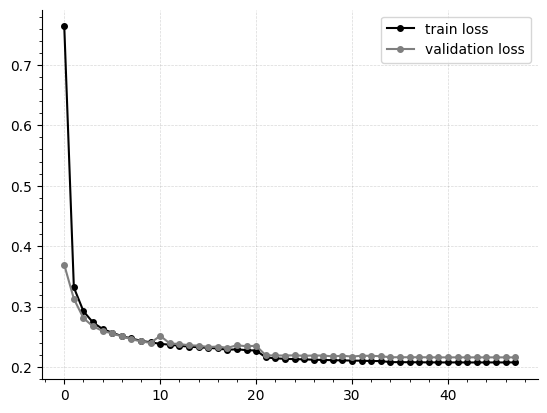

In [16]:
plt.plot(range(48), history.history["loss"], marker="o", label="train loss", color="k", markersize=4)
plt.plot(range(48), history.history["val_loss"], marker="o", label="validation loss", color="tab:gray", markersize=4)
plt.legend();

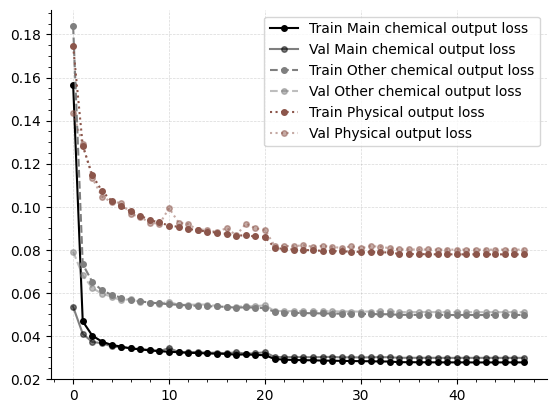

In [17]:
plt.plot(range(48), history.history["main_chemical_output_loss"], marker="o", label="Train Main chemical output loss", color="k", markersize=4)
plt.plot(range(48), history.history["val_main_chemical_output_loss"], marker="o", label="Val Main chemical output loss", color="k", alpha=0.5, markersize=4)

plt.plot(range(48), history.history["other_chemical_output_loss"], marker="o", ls="dashed", label="Train Other chemical output loss", color="tab:gray", markersize=4)
plt.plot(range(48), history.history["val_other_chemical_output_loss"], marker="o", ls="dashed", label="Val Other chemical output loss", color="tab:gray", alpha=0.5, markersize=4)

plt.plot(range(48), history.history["physical_output_loss"], marker="o", ls="dotted", label="Train Physical output loss", color="tab:brown", markersize=4)
plt.plot(range(48), history.history["val_physical_output_loss"], marker="o", ls="dotted", label="Val Physical output loss", color="tab:brown", alpha=0.5, markersize=4)

plt.legend();

In [19]:
y_true_phys_all = []
y_true_main_chem_all = []
y_true_other_chem_all = []

y_pred_phys_all = []
y_pred_main_chem_all = []
y_pred_other_chem_all = []

for x_batch, y_batch in test_ds:
    # 1) Get model predictions for this batch
    predictions = best_model(x_batch, training=False)
    pred_phys_batch = predictions['physical_output']
    pred_main_chem_batch = predictions['main_chemical_output']
    pred_other_chem_batch = predictions['other_chemical_output']

    # 2) Collect ground-truth values
    true_phys_batch = y_batch['physical_output']
    true_main_chem_batch = y_batch['main_chemical_output']
    true_other_chem_batch = y_batch['other_chemical_output']

    # 3) Append to our running lists
    y_true_phys_all.append(true_phys_batch.numpy())
    y_true_main_chem_all.append(true_main_chem_batch.numpy())
    y_true_other_chem_all.append(true_other_chem_batch.numpy())

    y_pred_phys_all.append(pred_phys_batch.numpy())
    y_pred_main_chem_all.append(pred_main_chem_batch.numpy())
    y_pred_other_chem_all.append(pred_other_chem_batch.numpy())

# 4) Concatenate the list of batches into a single array for each head
y_true_phys_all = np.concatenate(y_true_phys_all, axis=0)
y_true_main_chem_all = np.concatenate(y_true_main_chem_all, axis=0)
y_true_other_chem_all = np.concatenate(y_true_other_chem_all, axis=0)

y_pred_phys_all = np.concatenate(y_pred_phys_all, axis=0)
y_pred_main_chem_all = np.concatenate(y_pred_main_chem_all, axis=0)
y_pred_other_chem_all = np.concatenate(y_pred_other_chem_all, axis=0)

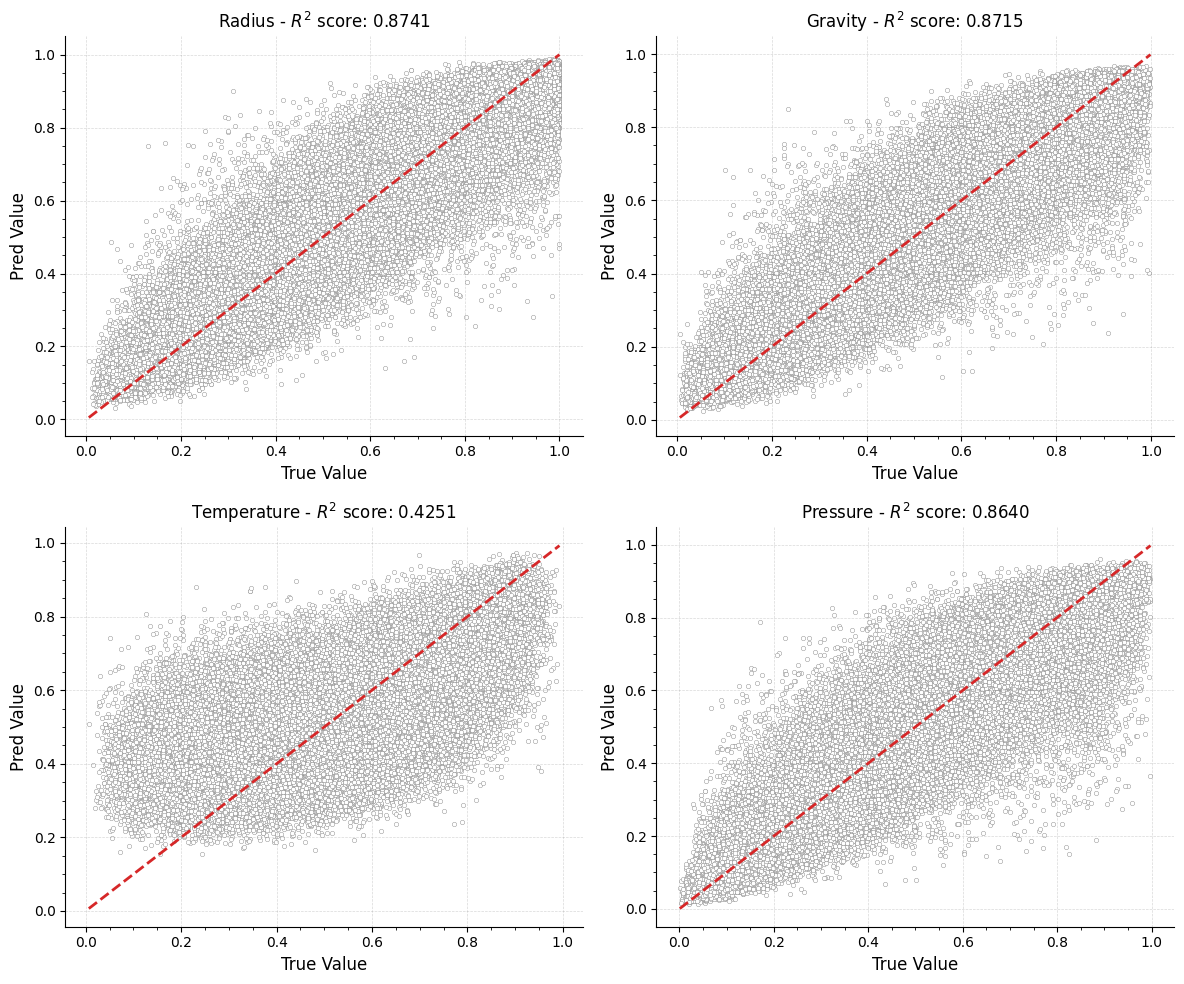

In [20]:
physical_parameters = ['Radius', 'Gravity', 'Temperature', 'Pressure']
n_keys = len(physical_parameters)
n_cols = 2
n_rows = int(np.ceil(n_keys / n_cols))

plt.figure(figsize=(12, 10))

metrics_list = []

for i, phys_param in enumerate(physical_parameters):
    phys_true = np.array([y_true_phys_all[row][i] for row in range(len(y_true_phys_all))])
    phys_pred = np.array([y_pred_phys_all[row][i] for row in range(len(y_pred_phys_all))])

    min_val = min(phys_true.min(), phys_pred.min())
    max_val = max(phys_true.max(), phys_pred.max())

    r2 = r2_score(phys_true, phys_pred)

    ax = plt.subplot(n_rows, n_cols, i+1)
    ax.plot([min_val, max_val], [min_val, max_val], ls="--", color="tab:red", lw=2)

    # Compute density using a 2D histogram
    #nbins = 100
    #hist, xedges, yedges = np.histogram2d(phys_true, phys_pred, bins=nbins)
    # For each point, determine which bin it falls into
    #xidx = np.clip(np.searchsorted(xedges, phys_true) - 1, 0, nbins-1)
    #yidx = np.clip(np.searchsorted(yedges, phys_pred) - 1, 0, nbins-1)
    # Map each point to its density value (the count in its bin)
    #z = hist[xidx, yidx]

    #sc = ax.scatter(phys_true, phys_pred, c=z, s=5, cmap='Greys_r', edgecolor='none')
    ax.scatter(phys_true, phys_pred, s=10, edgecolor="tab:gray", linewidth=0.3, color="w")
    #cb = plt.colorbar(sc, ax=ax, pad=0)
    #cb.set_label("Density")

    ax.set_title(fr'{physical_parameters[i]} - $R^2$ score: {r2:.4f}')
    ax.set_xlabel("True Value")
    ax.set_ylabel("Pred Value")

    mse = mean_squared_error(phys_true, phys_pred)
    rmse = np.sqrt(mse)
    mae = mean_absolute_error(phys_true, phys_pred)
    med_ae = median_absolute_error(phys_true, phys_pred)
    exp_var = explained_variance_score(phys_true, phys_pred)

    metrics_list.append({
        "Output": phys_param,
        "R²": r2,
        "Explained Variance": exp_var,
        "MSE": mse,
        "RMSE": rmse,
        "MAE": mae,
        "Median Absolute Error": med_ae
    })

df_metrics = pd.DataFrame(metrics_list)
plt.tight_layout();

In [21]:
df_metrics

Output        R²  Explained Variance       MSE      RMSE       MAE  \
0       Radius  0.874103            0.874105  0.008142  0.090233  0.066060   
1      Gravity  0.871473            0.871482  0.008331  0.091275  0.066747   
2  Temperature  0.425090            0.428041  0.022617  0.150389  0.118430   
3     Pressure  0.863965            0.864160  0.009158  0.095696  0.067426   

   Median Absolute Error  
0               0.048793  
1               0.049280  
2               0.097878  
3               0.046356

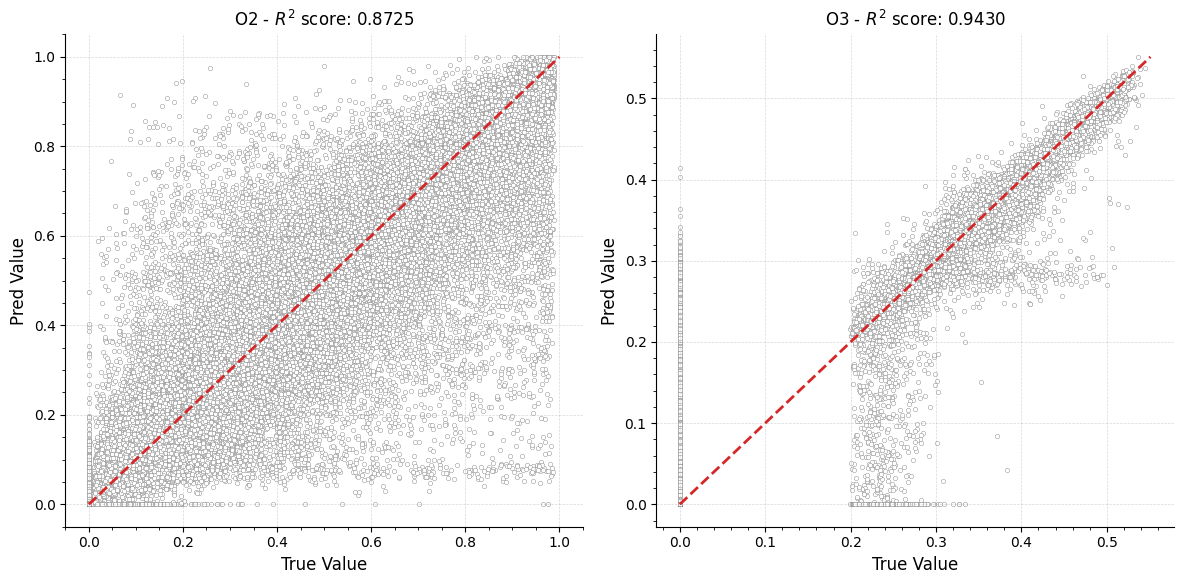

In [22]:
main_chemical_parameters = ['O2', 'O3']

n_keys = len(main_chemical_parameters)
n_cols = 2
n_rows = int(np.ceil(n_keys / n_cols))

plt.figure(figsize=(12, 6))

metrics_list = []

for i, chem_param in enumerate(main_chemical_parameters):
    chem_true = np.array([y_true_main_chem_all[row][i] for row in range(len(y_true_main_chem_all))])
    chem_pred = np.array([y_pred_main_chem_all[row][i] for row in range(len(y_pred_main_chem_all))])

    min_val = min(chem_true.min(), chem_pred.min())
    max_val = max(chem_true.max(), chem_pred.max())

    r2 = r2_score(chem_true, chem_pred)

    ax = plt.subplot(n_rows, n_cols, i+1)
    ax.plot([min_val, max_val], [min_val, max_val], ls="--", color="tab:red", lw=2)

    # Compute density using a 2D histogram
    #nbins = 50
    #hist, xedges, yedges = np.histogram2d(chem_true, chem_pred, bins=nbins)
    #xidx = np.clip(np.searchsorted(xedges, chem_true) - 1, 0, nbins-1)
    #yidx = np.clip(np.searchsorted(yedges, chem_pred) - 1, 0, nbins-1)
    #z = hist[xidx, yidx]

    # Scatter plot using density as color, with Greys_r cmap
    #sc = ax.scatter(chem_true, chem_pred, s=5, c=z, cmap='Greys_r', edgecolor="none", linewidth=0.3)
    ax.scatter(chem_true, chem_pred, s=10, edgecolor="tab:gray", linewidth=0.3, color="w")

    # Add colorbar with label "Density"
    #cb = plt.colorbar(sc, ax=ax, pad=0)
    #cb.set_label("Density")

    ax.set_title(fr'{main_chemical_parameters[i]} - $R^2$ score: {r2:.4f}')
    ax.set_xlabel("True Value")
    ax.set_ylabel("Pred Value")

    mse = mean_squared_error(chem_true, chem_pred)
    rmse = np.sqrt(mse)
    mae = mean_absolute_error(chem_true, chem_pred)
    med_ae = median_absolute_error(chem_true, chem_pred)
    exp_var = explained_variance_score(chem_true, chem_pred)

    metrics_list.append({
        "Output": chem_param,
        "R²": r2,
        "Explained Variance": exp_var,
        "MSE": mse,
        "RMSE": rmse,
        "MAE": mae,
        "Median Absolute Error": med_ae
    })

df_metrics_chem = pd.DataFrame(metrics_list)
plt.tight_layout()
plt.show()

In [23]:
df_metrics_chem

Output        R²  Explained Variance       MSE      RMSE       MAE  \
0     O2  0.872541            0.873246  0.011282  0.106216  0.052702   
1     O3  0.942995            0.943027  0.001608  0.040105  0.011623   

   Median Absolute Error  
0               0.017591  
1               0.002369

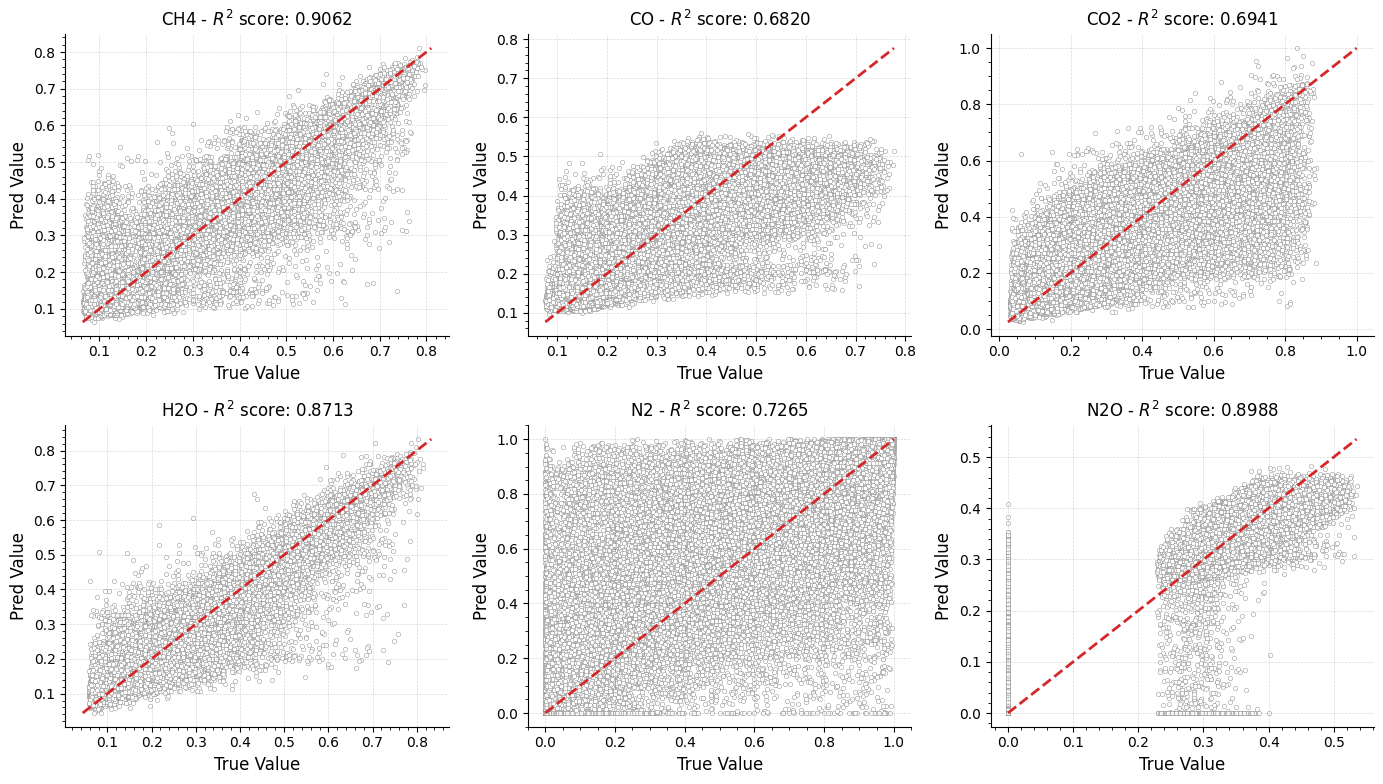

In [24]:
other_chemical_parameters = ['CH4', 'CO', 'CO2', 'H2O', 'N2', 'N2O']

n_keys = len(other_chemical_parameters)
n_cols = 3
n_rows = 2
plt.figure(figsize=(14, 8))

metrics_list = []

for i, chem_param in enumerate(other_chemical_parameters):
    chem_true = np.array([y_true_other_chem_all[row][i] for row in range(len(y_true_other_chem_all))])
    chem_pred = np.array([y_pred_other_chem_all[row][i] for row in range(len(y_pred_other_chem_all))])

    # Correct min and max values using both true and pred arrays
    min_val = min(chem_true.min(), chem_pred.min())
    max_val = max(chem_true.max(), chem_pred.max())

    r2 = r2_score(chem_true, chem_pred)

    ax = plt.subplot(n_rows, n_cols, i+1)
    ax.plot([min_val, max_val], [min_val, max_val], ls="--", color="tab:red", lw=2)

    # Compute density with a 2D histogram
    #nbins = 100
    #hist, xedges, yedges = np.histogram2d(chem_true, chem_pred, bins=nbins)
    #xidx = np.clip(np.searchsorted(xedges, chem_true) - 1, 0, nbins-1)
    #yidx = np.clip(np.searchsorted(yedges, chem_pred) - 1, 0, nbins-1)
    #z = hist[xidx, yidx]

    # Create the scatter plot using density for the color (Greys_r)
    #sc = ax.scatter(chem_true, chem_pred, s=5, c=z, cmap='Greys_r', edgecolor="none", linewidth=0.3)
    ax.scatter(chem_true, chem_pred, s=10, edgecolor="tab:gray", linewidth=0.3, color="w")

    # Add a colorbar with label "Density"
    #cb = plt.colorbar(sc, ax=ax, pad=0)
    #cb.set_label("Density")

    ax.set_title(fr'{other_chemical_parameters[i]} - $R^2$ score: {r2:.4f}')
    ax.set_xlabel("True Value")
    ax.set_ylabel("Pred Value")

    mse = mean_squared_error(chem_true, chem_pred)
    rmse = np.sqrt(mse)
    mae = mean_absolute_error(chem_true, chem_pred)
    med_ae = median_absolute_error(chem_true, chem_pred)
    exp_var = explained_variance_score(chem_true, chem_pred)

    metrics_list.append({
        "Output": chem_param,
        "R²": r2,
        "Explained Variance": exp_var,
        "MSE": mse,
        "RMSE": rmse,
        "MAE": mae,
        "Median Absolute Error": med_ae
    })

plt.tight_layout()

df_metrics_chem = pd.DataFrame(metrics_list)
plt.show()

In [25]:
df_metrics_chem

Output        R²  Explained Variance       MSE      RMSE       MAE  \
0    CH4  0.906227            0.906232  0.002520  0.050196  0.031995   
1     CO  0.681966            0.685862  0.005697  0.075476  0.053947   
2    CO2  0.694127            0.697501  0.009512  0.097532  0.064478   
3    H2O  0.871259            0.871377  0.001884  0.043408  0.027504   
4     N2  0.726495            0.730686  0.029157  0.170753  0.098491   
5    N2O  0.898825            0.899024  0.003092  0.055609  0.028661   

   Median Absolute Error  
0               0.021157  
1               0.038901  
2               0.040582  
3               0.016533  
4               0.041492  
5               0.016234

In [26]:
best_model.save('NN_22-tuner.keras')

In [27]:
# Just testing
model_load = tf.keras.models.load_model("/content/drive/MyDrive/Colab Notebooks/NN_22-tuner.keras")